In order to run this notebook you have to install the package `trump` in your computer that was created to make easier deal with the code base of this project. In the root folder of `trump` package you can run:
```python
pip3 install -e .
```
to install as a developer mode or
```python
pip3 install .
```
If you want, you can also bootstrap the virtual environment and run your notebook inside the virtual environment.
```bash
bash bootstrap-python-env.sh
source trump-env/bin/activate
jupyter notebook
```
This package was developed to make feasible read the code in the notebook, write tests for the functions and also to have a more manageable code base.

In [2]:
import sys
import re
import folium
import json
import pandas as pd
import numpy as np
from datetime import datetime

from trump import load, treat, text

from gensim import corpora
from wordcloud import WordCloud 
from gensim.models.ldamodel import LdaModel
from gensim.models.hdpmodel import HdpModel
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from PIL import Image
from tqdm import tqdm

from pprint import pprint
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

plots_args = {'fontsize': 14, 'color': '#9370DB'}

FIGURE_FOLDER = '../history/figures/'

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/lia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Demystifying POTUS, one tweet at a time...

Twitter plays a crucial role in politics these days. Gone are the days of door-to-door campaigning and trying to reach the last man. Today, power is weilded by those who can tweet. A carefully worded 140 character phrase carries the ability to swing states and potentially change the course of an entire nation. The goal of our project is to analyse the impact of Twitter on society and understand how ideas are spread across a network.

In order to investigate this question, our proposal is to analyse the tweets posted by Trump on Twitter over time to discover what was the main focus of his campaign, how it changed and how the society reacts to his discourses and proposals.

The Trump Twitter Archive is a project that has been collecting Trump's tweets since 2009 but the main focus of this project will be the period of his campaign.

# Milestone 2 addresses the following :

- Choose a word-scores dataset based on the amount of words available and also, the context (i.e., the context upon which the scores were built).
- Discover the window of time from where the tweets will be chosen so that it is feasible to develop the project in a machine with 8GB of RAM. The period of Trump's presidential campaign must be included in this interval.
- Perform a descriptive and exploratory analysis of tweets' text.
- Clean stop words from dataset.
- Check if LDA model is a feasible approach to find topics and then classify the tweets.
- Have a final proposal of the topics that will be analysed to answer the `Research Questions`.

All of this is answered in the next few sections.

##  Raw Data : Post-mortem

### Source

The Trump Twitter Archive project collects and updates tweets by trump on an hourly basis. The data is available here - [TrumpTwitterArchiveGithub](https://github.com/bpb27/trump_tweet_data_archive). The data is arranged in an yearly fashion into two kinds of `JSONs` - `condensed` and `master` (Eg. - `master_2016.json.zip` and `condensed_2016.json.zip`).

We will be using the master JSON files which contains the full response from Twitter's API. This will later give us the flexibility to add more analysis or drop some fields, if not required. Note that the JSON file for the year 2017 in the archive keeps changing every hour as it is updated with latest tweets.

### Format

The JSON contains an array of `Tweet Objects`. Following is as example of a tweet object :

In [3]:
with open('../data/master_2017.json') as f:
    for line in f:
        d = json.loads(line)
        
pprint(list(d[5].keys()))

['favorited',
 'contributors',
 'truncated',
 'is_quote_status',
 'in_reply_to_status_id',
 'user',
 'geo',
 'id',
 'favorite_count',
 'lang',
 'retweeted_status',
 'full_text',
 'entities',
 'created_at',
 'retweeted',
 'coordinates',
 'in_reply_to_user_id_str',
 'source',
 'in_reply_to_status_id_str',
 'in_reply_to_screen_name',
 'in_reply_to_user_id',
 'display_text_range',
 'place',
 'retweet_count',
 'id_str']


Because of space constraints, here we give a summary of the twitter data hierarchy (please follow the links for a detailed description) :

* [`Tweet`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object) : fundamental data structure encapsulating all information about a tweet

    ---
    
     >  created_at, id, id_str, text, source, truncated, is_quote_status, retweet_count, reply_count, retweeted, filter_level, *in_reply_to_status_id*, *in_reply_to_status_id_str*, *in_reply_to_user_id*, *in_reply_to_user_id_str*, *in_reply_to_screen_name*, *quoted_status_id*, *quoted_status_id_str*, *quote_count*, *favorite_count*, *favorited*, *possibly_sensitive*, *lang*, *matching_rules*, *current_user_retweet*, *withheld_copyright*, *withheld_in_countries*, *withheld_scope*
     
    ---
    
     > [`user`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object), [*`coordinates`*](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/geo-objects#coordinates-dictionary), [*`place`*](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/geo-objects#place-dictionary), [*`quoted_status`*](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object#tweet-dictionary), [*`retweeted_status`*](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object#tweet-dictionary), [`entities`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object), [*`extended_entities`*](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object), *`current_user_retweet`*, `scopes`, `geo`
     
* [`user`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object) : contains Twitter Account level metadata pertaining to a Twitter user/id

    ---
    
     >  id, id_str, name, screen_name, protected, verified, followers_count, friends_count, listed_count, favourites_count, statuses_count, created_at, geo_enabled, lang, contributors_enabled, profile_background_color, profile_background_image_url, profile_background_image_url_https, profile_background_tile, profile_banner_url, profile_image_url, profile_image_url_https, profile_link_color, profile_sidebar_border_color, profile_sidebar_fill_color, profile_text_color, profile_use_background_image, default_profile, default_profile_image, *location, url, description, utc_offset, time_zone, withheld_in_countries, withheld_scope*
     
    ---
    
     > `derived` 
     
     
* [`entities`, *`extended_entities`*](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object) : Contains object arrays of #hashtags, @mentions, $symbols, URLs, and media. Extended Entities contains up to four native photos, or one video or animated GIF.

     > [`hashtag`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#hashtags), [`media`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#media), [`media_size`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#media-size), [`url`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#urls), [`user_mention`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#mentions), [`symbol`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#symbols), [`poll`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#polls)
     
* [*`retweeted_status, quoted_status`*](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object) : contains a [`Tweet`](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object) object, present only if the current tweet is a retweet or quotes another tweet. Retweets are really made up of two Tweet objects (and two sets of child objects), with the ‘top level’ (Re)Tweet containing the original Tweet under the “retweeted_status” attribute.
     
 ----
 Aa : Atomic elements - always present
 
 *Aa* : Atomic elements - conditionally present
 
 `Aa` : objects - always present
 
 `Aa` : objects - conditionally present
 
 

### Preprocessing

Data is loaded using the `load_tweets` function in the `Trump` package. While loading we are executing the following steps in the pre-processing :

* Normalize the json to convert it into a columnar structure and load into a dataframe.
* Drop the undesired columns and limit* them to - created_at, favorite_count, user.id, etc. 
* Filter Trump's tweets as there were some tweets in the dataset which were not from him
* Filetr tweets which have missing text (around 1200 all from 2017)
* Convert the timestamp field *created_at* to a Pandas DateTime object
* Parse the columns to fetch* weekday, weekday_number, month_cohort, is_weekend, etc. ahead of time 


(*data snapshot in below cells)

## Dataset partition

- Choose a word-scores dataset based on the amount of words available and also, the context (i.e., the context upon which the scores were built).
- Discover the window of time from where the tweets will be chosen so that it is feasible to develop the project in a machine with 8GB of RAM. The period of Trump's presidential campaign must be included in this interval.


The amount of tweets is not as high as we expected, so it is feasible work with all the available years `{2009,...,2017}`. 

Be aware that the year of 2017 is not over yet, so fields like `retweet_count` may mutate if you download the dataset at any another instant of time. Besides that, the `as-of` of dataset in this repository of 2017 is `2017-11-24 14:00:00`.

In [4]:
df = load.load_tweets()

In [5]:
print('Dataset with {r} rows and size {s} MB \n'
      .format(r=len(df), s=round(sys.getsizeof(df)*1e-6, 1)))

HTML(df.head(2).T.to_html())

Dataset with 31224 rows and size 26.8 MB 



,1287,1288
id,881830110114009089,881697281233354753
created_at,2017-07-03 11:00:56,2017-07-03 02:13:07
favorite_count,69696,104824
lang,en,en
place.country,NaN,NaN
place.name,NaN,NaN
geo.coordinates,NaN,NaN
coordinates.coordinates,NaN,NaN
retweet_count,11325,25922
user.id,25073877,25073877


## Descriptive Analysis 

* Perform a descriptive and exploratory analysis of tweets' text.

### Number of tweets over time

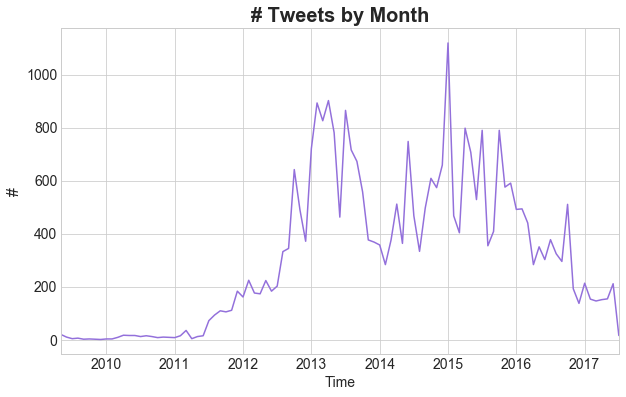

In [6]:
count_by_month = df.groupby('first_day_month_cohort').size()
count_by_month.plot(figsize=(10, 6), **plots_args);
plt.title('# Tweets by Month', fontsize=20, fontweight='bold'); 
plt.xlabel('Time', fontsize=14); plt.ylabel('#', fontsize=16);
plt.savefig(FIGURE_FOLDER + 'count_by_month.png')

We can observe a bump in Trump's Twitter activity around mid-2012. He annouced his campaign in middle of 2015 and there is no skip in the period.

### Missingness

In [7]:
def describe_missing(df):
    missing = []

    for c in df.columns:
        count_missing = pd.isnull(df[c]).sum()
        
        #only show columns with non-zero number of missing values
        if count_missing > 0:
            missing.append((c, round(count_missing*100 / df.shape[0], 2)))

    return pd.DataFrame(missing, columns=['col', '% missings']).set_index('col')

HTML(describe_missing(df).to_html())

,% missings
col,
place.country,90.84
place.name,90.84
geo.coordinates,92.64
coordinates.coordinates,92.64


Only the fields corresponding to location have missing values. One of our research questions is about geographic position, but seems like we won't be able to have a lot of accuracy and enough data to analyse. Let's [check](#Location) how `geo.coordinates` behaves over time. Moreover, since we are dealing with a single person's tweet, it may not be very insightful as the location of tweet may only be loosely related to its content.

### Device

This [blog post](http://varianceexplained.org/r/trump-tweets/) does a sentimental analysis of tweets split by device and it was found that certain types of devices tend to have more aggressive messages than others. Below we can see the number of tweets by device and quarter.

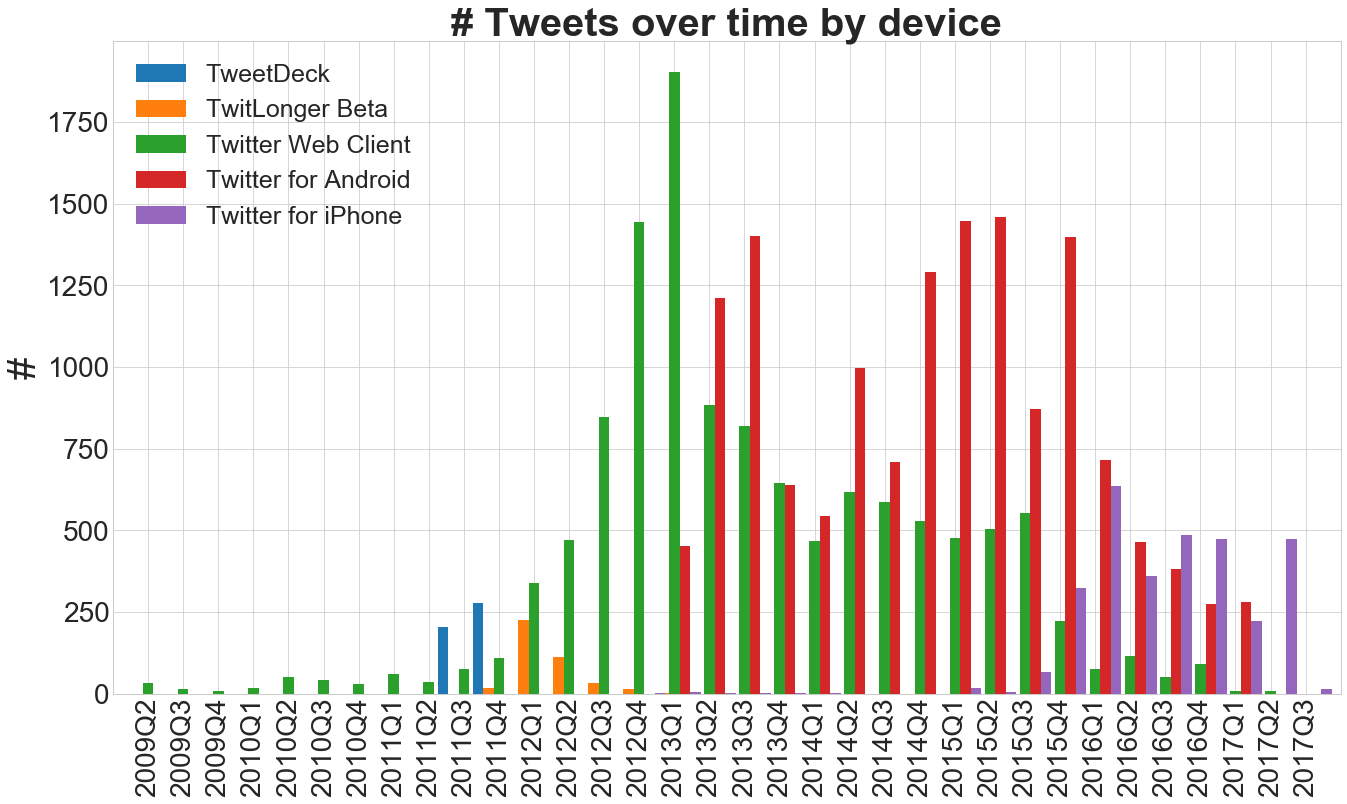

In [8]:
top_devices = (df.groupby('source').size()
               .sort_values(ascending=False)
               .iloc[0:5].index)
devices_over_time = (df[df['source'].apply(lambda x: x in top_devices)]
                     .groupby(['quarter_cohort', 'source'])
                     .size().unstack().fillna(0)
                     .plot(kind='bar', figsize=(22, 12), fontsize=28, width=1.5));
plt.title('# Tweets over time by device', fontsize=40, fontweight='bold'); 
plt.xlabel('', fontsize=40); 
plt.ylabel('#', fontsize=40);
plt.legend(fontsize=25)
plt.savefig(FIGURE_FOLDER + 'device_over_time.png')

From the chart above we can see that today Trump and his team uses mostly `iPhone` and `Android`. In the section [Clean and Analyse Text](#Clean-and-Analyse-Text) some analysis regarding the content of the tweet by device will be done.

### Weekday

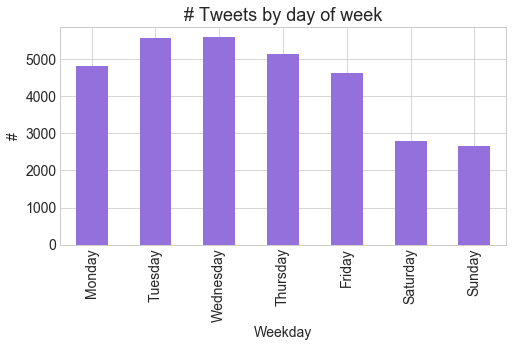

In [9]:
weekday = (pd.DataFrame(df.groupby(['weekday', 'weekday_number'])
                       .size()).reset_index()
           .sort_values('weekday_number')
           .set_index('weekday'))
del weekday['weekday_number'];
weekday.plot(kind='bar', figsize=(8, 4), legend=None, **plots_args);
plt.title('# Tweets by day of week', fontsize=18); 
plt.xlabel('Weekday', fontsize=14); plt.ylabel('#', fontsize=14);

As expected, the weekend is weaker than the others days but as we'll see in [Favorite](#Favorite) those are the best day to engage people.

### Location

In section [Missingness](#Missingness) the variable `geo.coordinates` has a lot of missing values, however they are well spreaded over time, so it is still worth doing the analysis of geo location

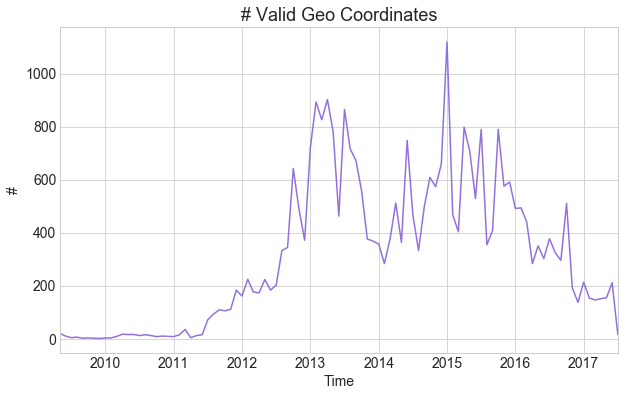

In [10]:
coord = df[['geo.coordinates', 'first_day_month_cohort']].copy()
coord['is_valid_coord'] = coord['geo.coordinates'].apply(lambda x: pd.notnull(str(x)))
coord_non_missing = coord.groupby('first_day_month_cohort').sum()

coord_non_missing.plot(figsize=(10, 6), legend=None, **plots_args);
plt.title('# Valid Geo Coordinates', fontsize=18); 
plt.xlabel('Time', fontsize=14); plt.ylabel('#', fontsize=14);

In [11]:
valid_geo = df[pd.notnull(df['geo.coordinates'])][['geo.coordinates', 'month_cohort', 'text']].values
m = folium.Map()

for tweet in valid_geo:
    folium.RegularPolygonMarker(tweet[0], 
                            popup=tweet[1],
                            fill_color='#45647d',
                            number_of_sides=4,
                            radius=1).add_to(m)
m.save('figures/map_tweets.html')

> ### [Check Tweet's map](https://rawgit.com/liabifano/project/master/analysis/figures/map_tweets.html)

The field `place.country` is calculated has the following distribution however is not that usefull because most of them are in United States

In [12]:
HTML(pd.DataFrame(pd.Series(df.groupby('place.country').size()).sort_values(ascending=False)).to_html())

,0
place.country,
United States,2784
United Kingdom,34
India,13
Ireland,9
Italy,7
Russia,3
Republic of Croatia,3
,3
Kingdom of Saudi Arabia,2


### Favorite
Based on the [twitter's documentation](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object) the field `favorite_count` is defined as the approximated how many times the tweet has been liked by Twitter's users.

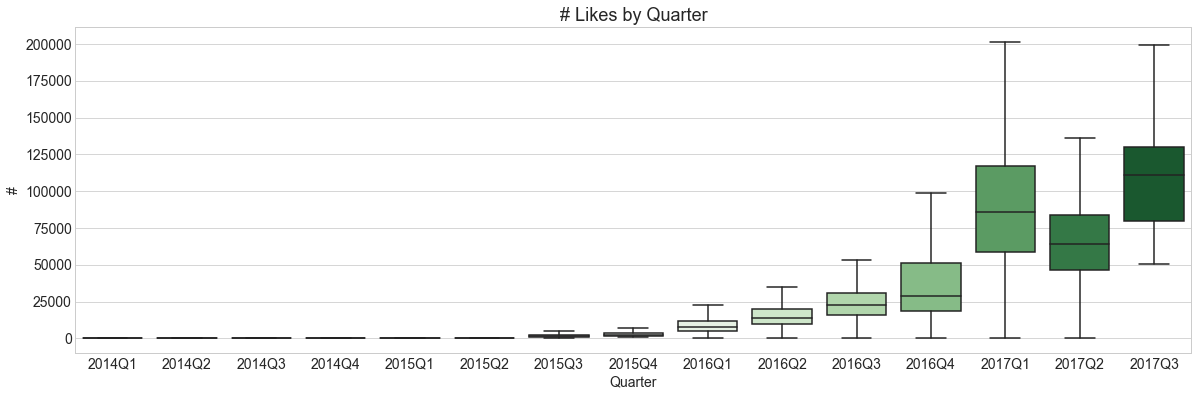

In [13]:
plt.figure(figsize=(20,6))
sns.boxplot(x='quarter_cohort', y='favorite_count',
            data=df[df['first_day_month_cohort'] > datetime(2014,1,1)].sort_values('first_day_month_cohort'), 
            showfliers=False, palette="PRGn");
plt.title('# Likes by Quarter', fontsize=18); 
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Quarter', fontsize=14); plt.ylabel('#', fontsize=14);

Another hypotesis is if the tweets in the weekend have a better chances to be liked, because people are more available in the weekends

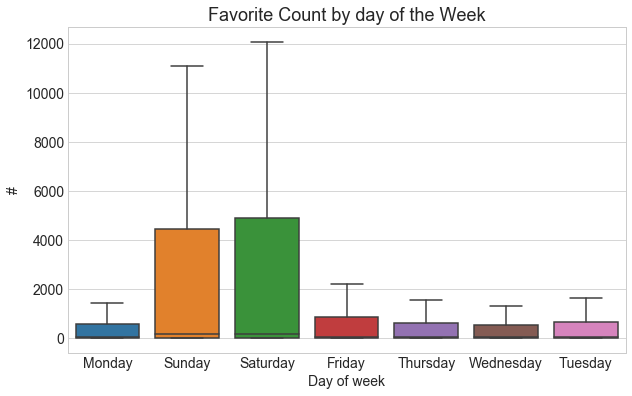

In [14]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(y='favorite_count', x='weekday', data=df, showfliers=False);
plt.title('Favorite Count by day of the Week', fontsize=18);
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Day of week', fontsize=14); plt.ylabel('#', fontsize=14);

### Retweets

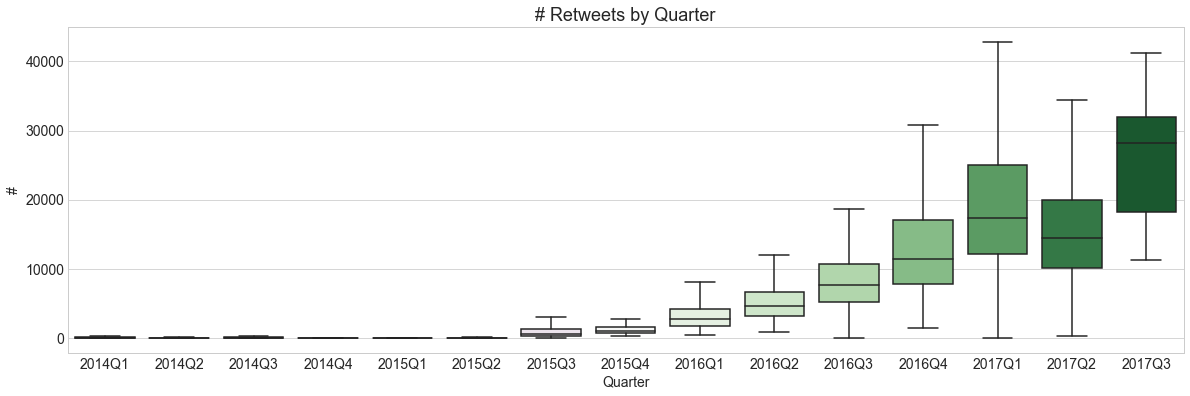

In [15]:
plt.figure(figsize=(20,6))
sns.boxplot(x='quarter_cohort', y='retweet_count',
            data=df[df['first_day_month_cohort'] > datetime(2014,1,1)].sort_values('first_day_month_cohort'), 
            showfliers=False, palette="PRGn");
plt.title('# Retweets by Quarter', fontsize=18); 
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Quarter', fontsize=14); plt.ylabel('#', fontsize=14);

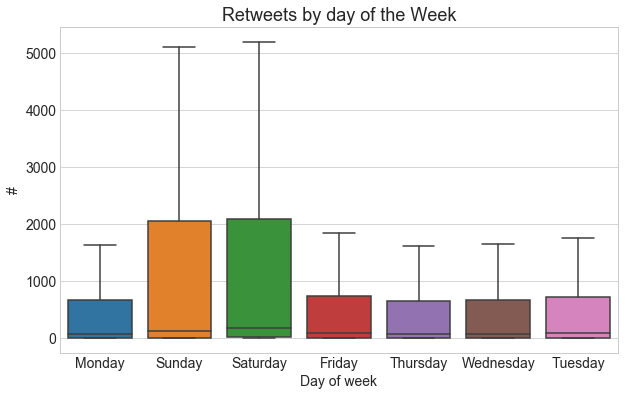

In [16]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(y='retweet_count', x='weekday', data=df, showfliers=False); # organize days
plt.title('Retweets by day of the Week', fontsize=18);
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Day of week', fontsize=14); plt.ylabel('#', fontsize=14);

**It can be noted that the behavior of retweets is the same as that of the likes**.

### Followers

The distribution of number of followers is very stable until middle of 2016, in the middle of 2016 the elections starts and it can be seen a spike. Another spike can be seen in the end of 2016 when he won the elections.

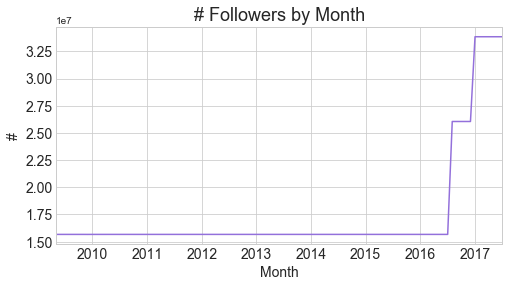

In [17]:
plt.figure(figsize=(8,4))
df.groupby('first_day_month_cohort').max()['user.followers_count'].plot(kind='line', **plots_args)
plt.title('# Followers by Month', fontsize=18); 
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Month', fontsize=14); plt.ylabel('#', fontsize=14);

## Clean and Analyse Text
* Clean stop words from dataset.

In [18]:
df['preprocessed_text'] = text.preprocessing_text(df['text'])
df['clean_text'] = text.remove_stop_words(df['preprocessed_text'])

After remove stop words, let's see what are the words that appear in hist tweets.

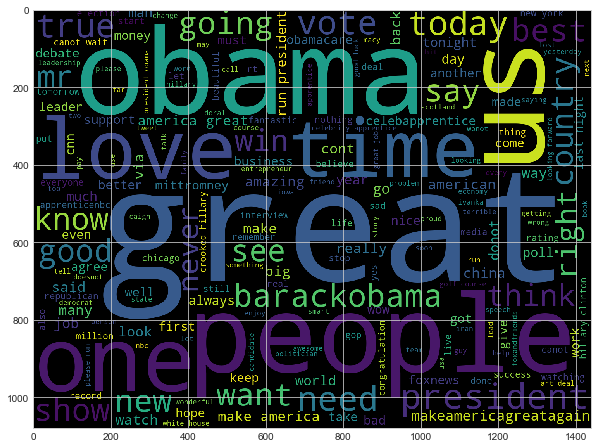

In [19]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
cloud = WordCloud(width=1440, height=1080).generate(' '.join(df['clean_text']));
ax.imshow(cloud);

Is this word count changing over time? Let's see how this is for every quarter.

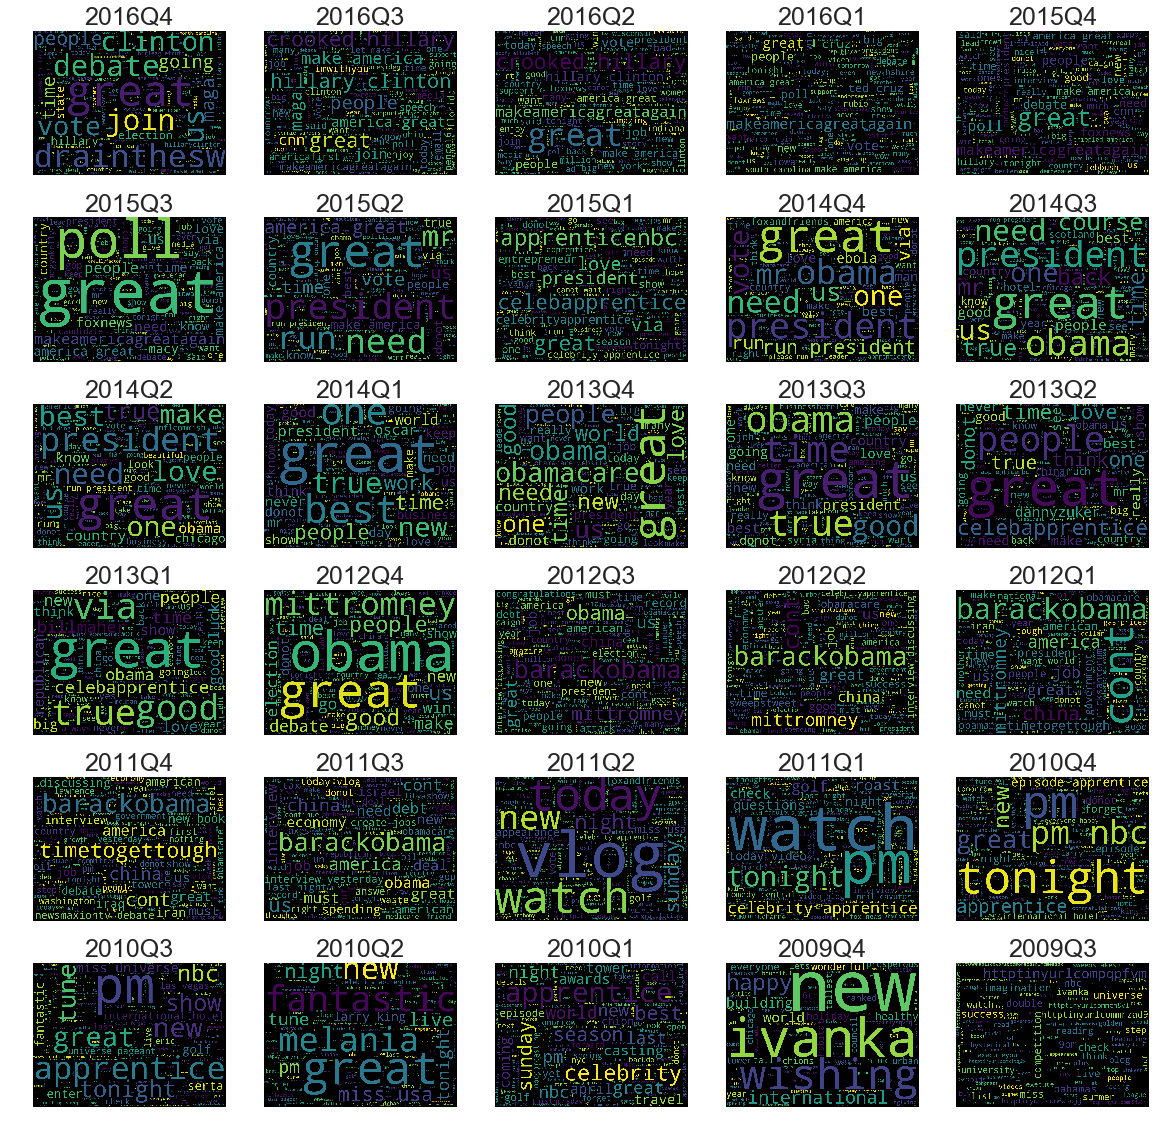

In [22]:
cohorts = df['quarter_cohort'].unique()[3:-1]

f, ax = plt.subplots(6, 5, figsize=(20, 20))
positions = np.array(range(30)).reshape(6, 5)
for num_c, c in enumerate(cohorts):
    pos = np.where(positions==num_c)
    
    tweets_cohort = df[df['quarter_cohort']==c]['clean_text']
    cloud = WordCloud(width=1440, height=1080).generate(' '.join(tweets_cohort));
    ax[pos[0][0], pos[1][0]].imshow(cloud);
    ax[pos[0][0], pos[1][0]].set_title('{c}'.format(c=c), fontsize=25)
    ax[pos[0][0], pos[1][0]].axis('off')
plt.savefig(FIGURE_FOLDER + 'word_cloud_by_semestre.png')

## Topics classification

* Check if LDA model is a feasible approach to find topics and then classify tweets.

In [37]:
def tweet_clean(texts):
    
    for tweet in texts:
        count = 0
        lis = []
        
        for word in tweet:
            condition = ('http' in word) or ('rt' == word) or ('www' in word) or ('w' == word) or ('cont' == word)
            if condition:
                lis.append(count)
            count = count + 1
    
        count = 0
        for l in lis:
            l = l - count
            del tweet[l]
            count = count + 1
    
    return texts

In [38]:
def corpus_creation(new_df, method):
    
    documents = list(new_df['clean_text'])
    
    stoplist = set(stopwords.words('english'))
    stoplist.add('amp')
    
    texts = [[word for word in document.lower().split() if word not in stoplist]for document in documents]
    
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
    texts = [[token for token in text if frequency[token] > 1] for text in texts]
    
    texts = tweet_clean(texts)
    
    if method != 'nmf':
        dictionary = corpora.Dictionary(texts)
        corpus = [dictionary.doc2bow(text) for text in texts]
        return corpus, dictionary
    
    else:
        doc = " ".join(word for tweet in texts for word in tweet)
        doc = doc.split(" ")
        tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
        tfidf = tfidf_vectorizer.fit_transform(doc)
        tfidf_feature_names = tfidf_vectorizer.get_feature_names()
        return tfidf, tfidf_feature_names

In [39]:
def display_topics(model, feature_names, no_top_words):
    
    mod = []
    for topic_idx, topic in enumerate(model.components_):
        t = ()
        # print("Topic {}:".format(topic_idx))
        t = t + (topic_idx,)
        lis = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        # print(lis)
        t = t + (lis,)
        mod.append(t)
    return mod

In [40]:
def topic_modelling(start_date, end_date, method, original_df, num_topics, num_words):
    
    mask = (original_df['created_at'] > start_date) & (original_df['created_at'] <= end_date)
    new_df = original_df.loc[mask]
    
    if method != 'nmf':
        corpus, dictionary = corpus_creation(new_df, method)
    
    else:
        tfidf, tfidf_feature_names = corpus_creation(new_df, method)
        
    if method == 'lda':
        lda = LdaModel(corpus, id2word = dictionary, num_topics = num_topics)
        model = lda.print_topics(num_topics= num_topics, num_words = num_words)
    if method == 'hdp':
        hdp = HdpModel(corpus, id2word = dictionary)
        model = hdp.print_topics(num_topics = num_topics, num_words = num_words)
    if method == 'nmf':
        nmf = NMF(n_components = num_topics, alpha = 0.1, l1_ratio = 0.5, init = 'nndsvd').fit(tfidf)
        model = display_topics(nmf, tfidf_feature_names, num_words)
        
    return model

In [41]:
def create_wordle(model):
    
    wordle = []
    for i in range(len(model)):
        string = model[i][1]
        words = " ".join(re.findall("[a-zA-Z]+", string))
        wordle.extend(words.split())
    return wordle

In [42]:
def topic_viz(df, method, num_topics, num_words):
    
    cohorts = df['quarter_cohort'].unique()[0:-4]
    
    f, ax = plt.subplots(6, 5, figsize=(20, 20))
    positions = np.array(range(30)).reshape(6, 5)
    
    for i, quarter in tqdm(enumerate(cohorts)):
        
        pos = np.where(positions == i)
        
        start_date = quarter.start_time
        end_date = quarter.end_time
        
        model = topic_modelling(start_date, end_date, method, df, num_topics, num_words)
        
        wordle = create_wordle(model)
        
        freq = Counter(wordle)
        
        #mask = np.array(Image.open("trump.jpg"))
        cloud = WordCloud(width=1640, height=1280, max_words=100).fit_words(freq);
        
        ax[pos[0][0], pos[1][0]].imshow(cloud);
        ax[pos[0][0], pos[1][0]].set_title('Quarter: {}'.format(quarter))
        ax[pos[0][0], pos[1][0]].axis('off')

Now that we have all functions in order, let's have a look at some of the results.

Firstly, we'll try to look at the results of applying LDA on all the tweets.

In [43]:
start_date = '2009-05-01'
end_date = '2017-10-01'
method = 'lda'
num_topics = 8
num_words = 8

In [46]:
model = topic_modelling(start_date, end_date, method, df, num_topics, num_words)
pprint(model)

[(0,
  '0.015*"new" + 0.014*"great" + 0.014*"interview" + 0.013*"pm" + 0.013*"book" '
  '+ 0.011*"via" + 0.010*"tonight" + 0.009*"2012"'),
 (1,
  '0.019*"president" + 0.019*"golf" + 0.016*"think" + 0.016*"run" + '
  '0.014*"happy" + 0.012*"like" + 0.011*"course" + 0.011*"would"'),
 (2,
  '0.017*"china" + 0.015*"us" + 0.015*"great" + 0.011*"interview" + '
  '0.009*"needs" + 0.009*"hope" + 0.009*"america" + 0.008*"doral"'),
 (3,
  '0.018*"obama" + 0.011*"oil" + 0.009*"true" + 0.009*"debt" + 0.008*"last" + '
  '0.008*"never" + 0.007*"money" + 0.007*"mittromney"'),
 (4,
  '0.065*"barackobama" + 0.011*"show" + 0.011*"one" + 0.010*"miss" + '
  '0.010*"apprentice" + 0.009*"night" + 0.009*"new" + 0.009*"great"'),
 (5,
  '0.018*"discussing" + 0.011*"art" + 0.009*"house" + 0.009*"ivanka" + '
  '0.009*"sure" + 0.008*"scotland" + 0.007*"beautiful" + 0.007*"video"'),
 (6,
  '0.015*"obama" + 0.014*"obamacare" + 0.011*"season" + 0.010*"must" + '
  '0.009*"iran" + 0.009*"get" + 0.009*"us" + 0.008*"chi

We obtain a list of 8 topics, described by 8 words each (as specified by the input parameters).

As we can see, there isn't much clarity on what those 8 words are trying to say about each topic. Also, pretty major topics like `fake news`, `hillary clinton`, `immigration` seem to be missing entirely. We believe that this might be happening due to the large time-scale that we are choosing. Let's try and narrow down our search window and judge whether we obtain something better.

Specifically, let's narrow down to the last three months before elections, the time when the competition between Hillary and Trump was at its peak.

In [47]:
start_date = '2016-08-08'
end_date = '2016-11-08'
method = 'lda'

In [48]:
model = topic_modelling(start_date, end_date, method, df, num_topics, num_words)
pprint(model)

[(0,
  '0.021*"clinton" + 0.014*"join" + 0.014*"hillary" + 0.012*"imwithyou" + '
  '0.011*"poll" + 0.011*"iowa" + 0.010*"americafirst" + 0.009*"tomorrow"'),
 (1,
  '0.017*"great" + 0.016*"hillary" + 0.014*"maga" + 0.010*"people" + '
  '0.010*"drainthesw" + 0.010*"going" + 0.009*"clinton" + 0.009*"make"'),
 (2,
  '0.025*"clinton" + 0.018*"maga" + 0.014*"imwithyou" + 0.012*"hillary" + '
  '0.011*"debate" + 0.010*"makeamericagreatagain" + 0.009*"tonight" + '
  '0.009*"americafirst"'),
 (3,
  '0.018*"get" + 0.015*"great" + 0.013*"join" + 0.012*"makeamericagreatagain" '
  '+ 0.010*"america" + 0.010*"ohio" + 0.010*"live" + 0.009*"watch"'),
 (4,
  '0.032*"hillary" + 0.023*"great" + 0.015*"clinton" + 0.012*"crooked" + '
  '0.011*"debate" + 0.010*"make" + 0.009*"america" + 0.008*"last"'),
 (5,
  '0.020*"bigleaguetruth" + 0.013*"hillaryclinton" + 0.013*"great" + '
  '0.013*"hillary" + 0.012*"debate" + 0.012*"clinton" + 0.012*"team" + '
  '0.009*"join"'),
 (6,
  '0.016*"clinton" + 0.015*"crooked"

These set of topics seem to be much better than the last set. We can clearly observe Trump's focus on `debate night`, `crooked hillary` and `ohio elections`. This was indeed what was happening during those months.

So, as we thought, indeed it was the trouble with choosing the correct timeframe for topic modelling.

Let's try to see results with other methods for the same set of dates.

In [49]:
# Negative Matrix Factorization
method = 'nmf'
model = topic_modelling(start_date, end_date, method, df, num_topics, num_words)
pprint(model)

[(0, 'hillary york foundation geneva gave gates future friends'),
 (1, 'clinton york foundations genflynn geneva gave gates future'),
 (2, 'great york foundation geneva gave gates future friends'),
 (3, 'join york foundation geneva gave gates future friends'),
 (4, 'maga york gets geneva gave gates future friends'),
 (5, 'america york foundations genflynn geneva gave gates future'),
 (6, 'drainthesw york foundations genflynn geneva gave gates future'),
 (7, 'debate york getting genflynn geneva gave gates future')]


Very less variance in topics, repetitive topic words, overall - not better than LDA.

In [50]:
# Hierarchical Dirichlet Process
method = 'hdp'
model = topic_modelling(start_date, end_date, method, df, num_topics, num_words)
pprint(model)

[(0,
  '0.005*morning + 0.005*making + 0.005*oreillyfactor + 0.004*miami12pm + '
  '0.004*immigration + 0.004*without + 0.004*believe + 0.004*health'),
 (1,
  '0.005*attn + 0.005*praised + 0.005*need + 0.005*turn + 0.004*worst + '
  '0.004*obamacare + 0.004*jones + 0.004*available'),
 (2,
  '0.005*hook + 0.005*florida + 0.005*supported + 0.005*defeat + 0.004*use + '
  '0.004*wouldnot + 0.004*protects + 0.004*important'),
 (3,
  '0.006*vpdebate + 0.005*night + 0.005*take + 0.005*reset + 0.005*fail + '
  '0.005*delivered + 0.005*speech + 0.005*team'),
 (4,
  '0.006*reception + 0.005*mn + 0.005*mosul + 0.005*lose + 0.004*crowd + '
  '0.004*carolina + 0.004*enjoyed + 0.004*supported'),
 (5,
  '0.006*spent + 0.005*tune + 0.005*enforcement + 0.005*come + 0.005*staffers '
  '+ 0.005*appreciate + 0.005*show + 0.005*threat'),
 (6,
  '0.006*empowering + 0.005*graham + 0.004*participating + 0.004*instead + '
  '0.004*greeley + 0.004*turning + 0.004*stance + 0.004*ivanka'),
 (7,
  '0.008*close + 0

There's a higher variance of topics, topics are easily comprehensible from the generated topic words. Overall, seems better than LDA.

Now let's try to visualize topics on a quarterly basis, starting from 2010Q2. WordCLoud Viz is used for each quarter, using all the topic words obtained for each quarter.

30it [02:27,  4.90s/it]


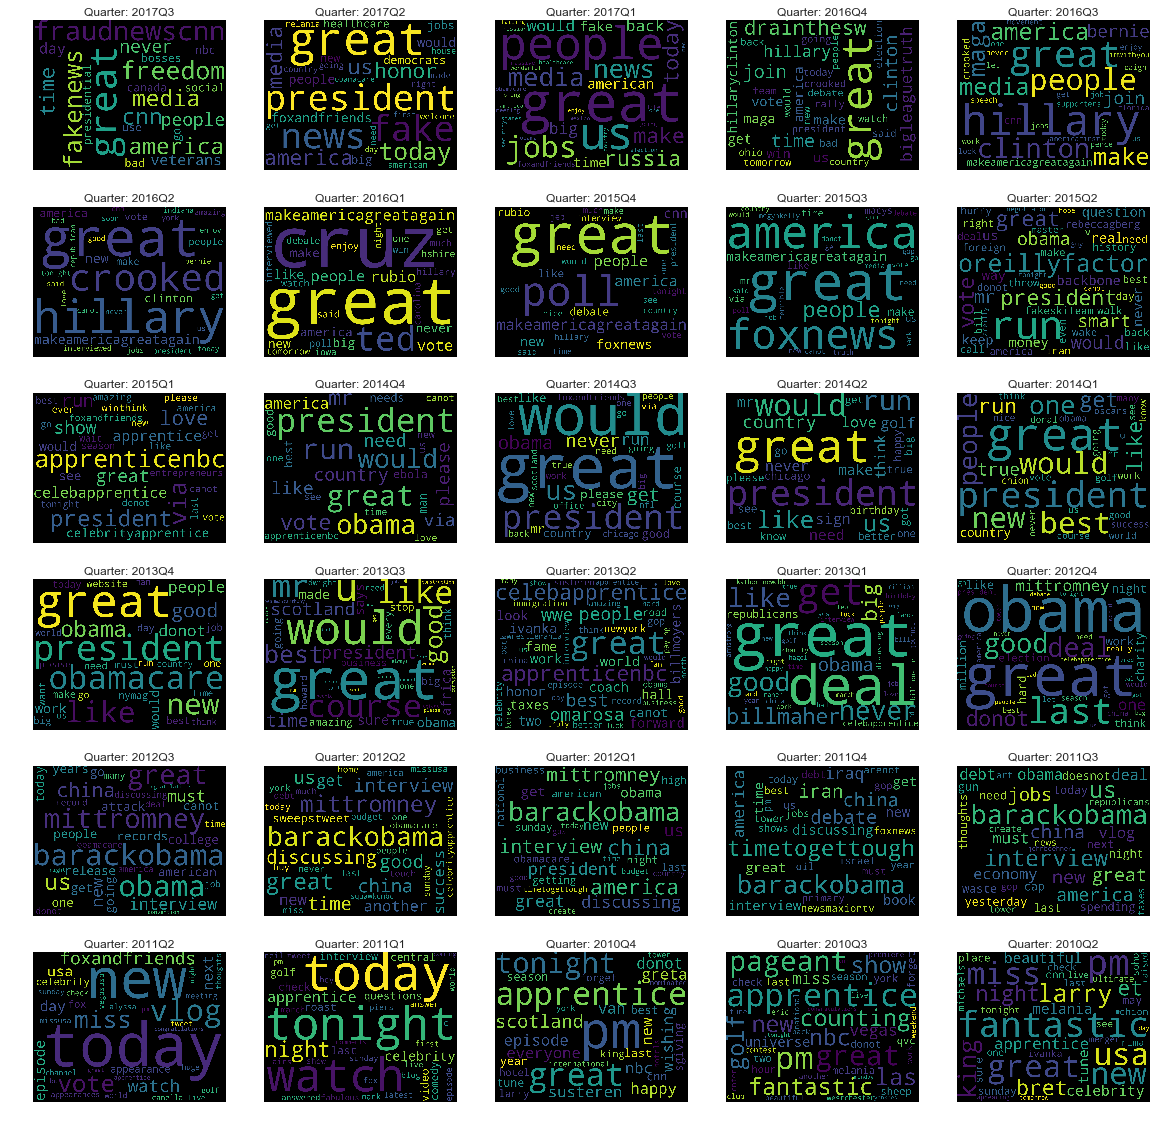

In [51]:
method = 'lda'
topic_viz(df, method, num_topics, num_words)

## Research Questions

* Have a final proposal of the topics that will be analysed to answer the `Research Questions`

### How linguistic tones create an impact?

* Sentiment Analysis - breaking down tweets into positive, neutral and negative remarks to figure out how Trump uses language to create an impact. This might also extend to recording the use of exclamation marks and capitalised words to measure the unambiguity of the tweet emotion.
* Ego Analysis - finding occurences involving the use of self to promote an idea/situation. This might give us important insights about the impact of his tweets.

Sentiments analysis will be performed using a pre-defined model.

Impact may be measured by measuring the increase in followers and/or counting the number of retweets and likes for each kind of sentiment expressed in the tweet.

We may not be going ahead with the particular idea - "recording the use of exclamation marks and capitalised words to measure the unambiguity of the tweet emotion" because we will be cleaning most of the data so that we get better results in sentiment analysis and topic modelling.

We may also not go ahead with this particular idea - "finding occurences involving the use of self to promote an idea/situation" because of similar reasons.

### Is it okay to generalize the sentiments based on ALL the tweets?

* Source Anaylsis - almost all major political players have an additional media team who handle their Twitter Account. Same can be said about Trump. We can analyze the metadata to find out if the tweet has been sent out by the media team or Trump himself. For example, we can have a look at the source of the tweet. (sent by iPhone/Android). This can help us in analyzing the tweets in a better way.

We will perform sentiment analysis and topic modelling on both cluster of tweets (ones obtained by iPhone and ones obtained by Android). We hope to get significantly different results for both clusters. Further analysis may nvolve filtering down the data based on one particular source.

Further follow-up maybe analyzing the number of retweets, likes - maybe a measure of how `sensational` the tweet is. Hypothesis - most likely to come from Android.

### Is it all about the timing?

* Temporal Analysis - this involves a broad spectrum of topics, ranging from analyzing Trump's favorite time of the day to tweet vs its impact to how his number of followers get affected as an aftermath of a sensational tweet and in general, analyzing the changing preference of voters through time.

Most of the analysis will involve uncovering the time patterns hidden behind the tweet data. This will give us insights as to when Trump is highly active, what is the popularity index of the tweet according to post time and whether there has been a change in tweet time trend before, during and after the campaign.

Define `sensational`, measure the corrleation between retweets and tweet timings.

We will not be going ahead with this particular idea - "analyzing the changing preference of voters through time" because our dataset involves only Trump's tweets only, so it isn't possible to gauge voter preferences.

### What are the distinct themes across tweets?

* Clustering Analysis - the tweets will be split into clusters based on its main topic. The cluster might be extracted by a heuristic logic based on a descriptive analysis of tweets or by Latent Dirichlet allocation (LDA) if it is feasible. We can then perform aforementioned temporal analysis for each topic.

As seen in the cells above, topic modelling pipeline using LDA indeed gives favorable results.

Other techniques like Hierarchical Dirichlet Process (HDP) and Negative Matrix Factorization (NMF) have also been explored in this Notebook, out of which HDP seems promising.

Another possible approach is to mine the topics from new sources to fetch topics/keywords relevant to US politics and related campaigns during the year of campaigning and elections.

We will be choosing upto 10 dominant clusters from the topic modelling pipeline and then proceed to assign topic to each of the tweets. Sentiment and Temporal Analysis into each of the following clusters are likely to reveal more insights into Trump's preferred topics and overall impacts of those topics.

As seen earlier, there is a significantly huge amount of missing geo-coordinate data (93 % missing). Hence, we will not be going ahead with this analysis.

## Data Story and Final Presentation

We will be presenting the results in the form of a data story.


## Next Steps
For the next step of this project the following analysis will be done:

#### Sentimental Analysis
- Among the datasets with sentimental score, we decided to move on with [
NRC Word-Emotion Association Lexicon](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm) dataset because it has a lot of different categories that can be transformed into positive and negative emotions like [David Robinson](http://varianceexplained.org/r/trump-tweets/) did in his blog post.
- After have the relative count of emotions by tweet we'll analyse the distribution of number of retweets and followers.


#### Topics inference
- Extract the morphological meaning of each word using [nltk](http://www.nltk.org/) library and try again run `LDA` model to infer topics. And if we are successful to get meanful topics, we'll count by time to see if the distribution changes over time.
- This [post](https://www.tensorflow.org/tutorials/word2vec) shows how to `word2vec` and `t-SNE` to visualize words that appears together. We will apply the same analysis in our dataset.